In [ ]:
import torch
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
  
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Geting our drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

drive/  sample_data/


In [ ]:
#train_dataset_path = "/content/drive/MyDrive/Dataset/train"
#test_dataset_path = "/content/drive/MyDrive/Dataset/test"

In [ ]:
train_dataset_path = "/content/drive/MyDrive/Colab Notebooks/Alzheimers disease /Dataset/train"
test_dataset_path = "/content/drive/MyDrive/Colab Notebooks/Alzheimers disease /Dataset/test"

In [ ]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

train_transforms = transforms.Compose([
                                       transforms.Resize((224,224)),
                                      # transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(10),
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
                                       ])

test_transforms = transforms.Compose([
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
                                       ])

In [ ]:
train_set = torchvision.datasets.ImageFolder(root= train_dataset_path, transform= train_transforms)
test_set = torchvision.datasets.ImageFolder(root= test_dataset_path, transform= test_transforms)

In [ ]:
def show_transformed_images(dataset):
  loader = torch.utils.data.DataLoader(dataset, batch_size= 6, shuffle= True)
  batch = next(iter(loader))
  images, labels = batch

  grid = torchvision.utils.make_grid(images, nrow= 3)
  plt.imshow(np.transpose(grid, (1,2,0)))
  print("labels: ", labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([2, 0, 2, 2, 3, 2])


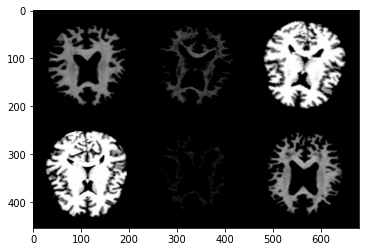

In [ ]:
show_transformed_images(train_set)

In [ ]:
print(len(train_set))
print(len(test_set))

20000
4000


Visualizing Dataset

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import seaborn as sns

In [ ]:
# Don't run this one 
valid_size= 0.2 # taking 20% data as out validation set
num_train = len(train_set)
indices = list(range(num_train))
print('Total number of our train data: ',len(indices))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
#print(split)
train_idx, valid_idx = indices[split:], indices[:split]
print('After splitting train data: ',len(train_idx))
print('After splitting validation data: ',len(valid_idx))

Total number of our train data:  20000
After splitting train data:  16000
After splitting validation data:  4000


In [ ]:
num_workers = 0
batch_size = 32

# obtain training indices that will be used for validation
valid_size= 0.2 # taking 20% data as out validation set
num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

print('After splitting train data: ',len(train_idx))
print('After splitting validation data: ',len(valid_idx))

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
# image classes
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

After splitting train data:  16000
After splitting validation data:  4000


In [ ]:
dataiter = iter(valid_loader)
images, labels = dataiter.next()
images.shape

torch.Size([32, 3, 224, 224])

In [ ]:
%matplotlib inline

# helper function to display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

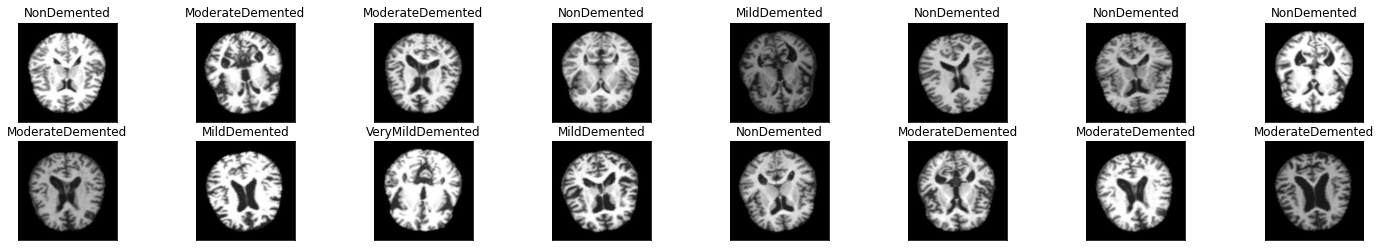

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # Converted Image to numpy

# plot the images in the batch, along with the corresponding labels

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

**Training Model**

In [ ]:
# Taking vgg16 model 
from torchvision import models
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# change the number of classes  
# We have taken 4 output features as we have 4 classes images 
vgg16.classifier[2] = nn.Dropout(p= 0.5, inplace= False)
vgg16.classifier[3] = nn.Linear(4096, 1024)
vgg16.classifier[6] = nn.Linear(1024, 4)
vgg16.classifier[5] = nn.Dropout(p= 0.5, inplace= False)
# freeze convolution weights
#for param in vgg16.features.parameters():
 #   param.requires_grad = False

Parameters should be frezzed

In [ ]:
vgg16.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# optimizer
#optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.0001, momentum=0.9 ) #weight_decay= 5e-4
optimizer = optim.Adam(vgg16.classifier.parameters(), lr = 0.001, betas= (0.9, 0.999), eps= 1e-8, weight_decay=0)
# loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss
valid_list= []  # stores validation losses
train_list= []  # stores train losses

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    vgg16.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = vgg16(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    vgg16.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        output = vgg16(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(vgg16.state_dict(), 'model_alzheimer2.pt')
        valid_loss_min = valid_loss

    train_list.append(train_loss)
    valid_list.append(valid_loss)
    

Epoch: 1 	Training Loss: 0.716625 	Validation Loss: 0.558297
Validation loss decreased (inf --> 0.558297).  Saving model ...
Epoch: 2 	Training Loss: 0.660973 	Validation Loss: 0.515996
Validation loss decreased (0.558297 --> 0.515996).  Saving model ...
Epoch: 3 	Training Loss: 0.649381 	Validation Loss: 0.495365
Validation loss decreased (0.515996 --> 0.495365).  Saving model ...
Epoch: 4 	Training Loss: 0.683841 	Validation Loss: 0.569350
Epoch: 5 	Training Loss: 0.697325 	Validation Loss: 0.574565
Epoch: 6 	Training Loss: 0.685486 	Validation Loss: 0.512683
Epoch: 7 	Training Loss: 0.704770 	Validation Loss: 0.559335


In [ ]:
valid_list

[0.24593359196186065]

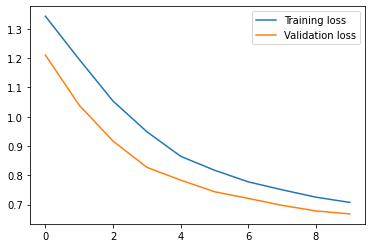

In [ ]:
# plotting the training and validation loss
plt.plot(train_list, label='Training loss')
plt.plot(valid_list, label='Validation loss')
plt.legend()
plt.show()
#need two array here to store the validation and train loss value for each epochs

In [ ]:
vgg16.load_state_dict(torch.load('model_alzheimer2.pt'))

<All keys matched successfully>

In [ ]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)

Calculating Accuracy

In [ ]:
n_corrects= 0
n_samples= 0

vgg16.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    _, pred = torch.max(output, 1)    
    n_corrects += (pred== target).sum().item()
    n_samples += target.size(0)

print(f'Overall accuracy {(n_corrects / n_samples)*100}%')

Overall accuracy 46.45%


In [ ]:
n_corrects= 0
n_samples= 0

vgg16.eval()
# iterate over test data
for data, target in valid_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    _, pred = torch.max(output, 1)    
    n_corrects += (pred== target).sum().item()
    n_samples += target.size(0)

print(f'Overall accuracy {(n_corrects / n_samples)*100}%')

Overall accuracy 68.825%


In [ ]:
n_corrects= 0
n_samples= 0

vgg16.eval()
# iterate over test data
for data, target in train_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    _, pred = torch.max(output, 1)    
    n_corrects += (pred== target).sum().item()
    n_samples += target.size(0)

print(f'Overall accuracy {(n_corrects / n_samples)*100}%')

Overall accuracy 70.5125%


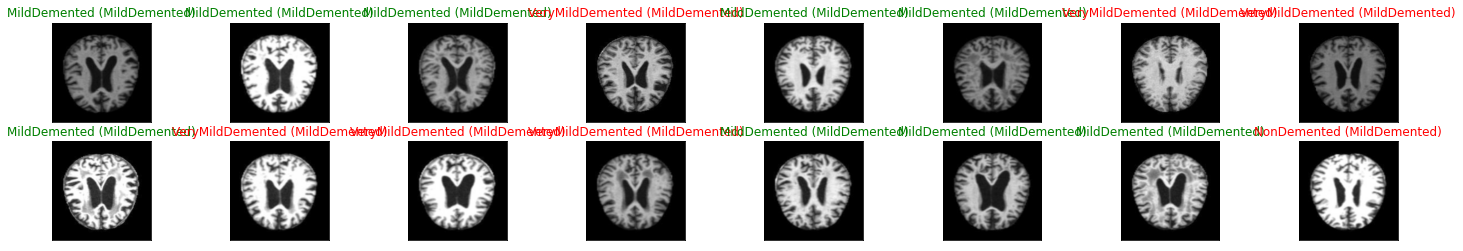

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [ ]:
print(len(test_set))
print(len(test_set.targets))

In [ ]:
@torch.no_grad()
def prediction(cnn, batch_loader):
  total_preds = torch.tensor([]).cuda()
  for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    #print(len(output))
    # convert output probabilities to predicted class
    _,pred = torch.max(output, 1) 
    #print(pred)
    total_preds = torch.cat(
            (total_preds, output)
            ,dim=0
        )
  return total_preds

In [ ]:
# Function to plot confusion matrix

from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
with torch.no_grad():
    test_prediction_loader = torch.utils.data.DataLoader(test_set, batch_size=16)
    test_preds = prediction(vgg16, test_prediction_loader)

Confusion matrix, without normalization


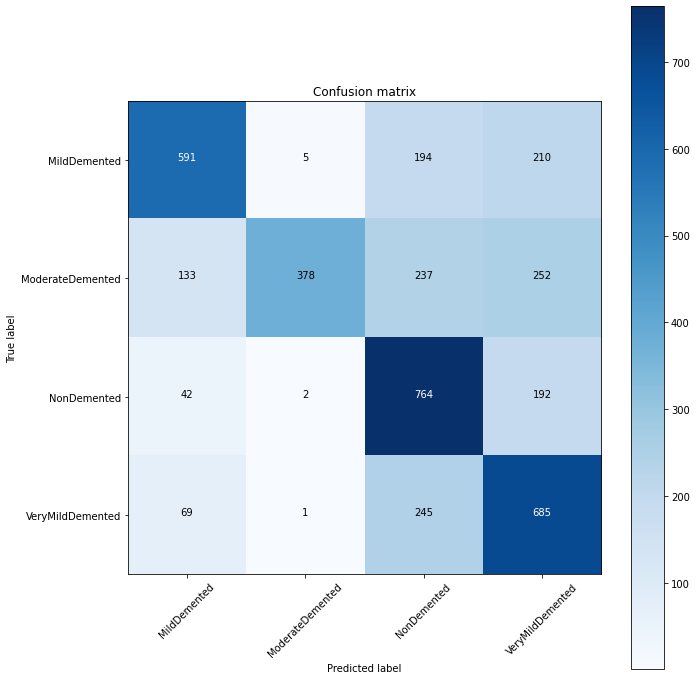

In [ ]:
test_preds = test_preds.cpu()
conf_matrix = confusion_matrix(test_set.targets, test_preds.argmax(dim= 1))
plt.figure(figsize=(10,10))
plot_confusion_matrix(conf_matrix, train_set.classes)

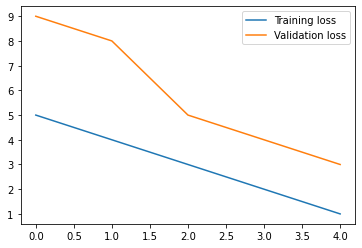

In [ ]:
# plotting the training and validation loss
a = [5,4,3,2,1]
b= [9,8,5,4,3]
plt.plot(a, label='Training loss')
plt.plot(b, label='Validation loss')
plt.legend()
plt.show()
#need two array here to store the validation and train loss value for each epochs